In [2]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime

In [3]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [4]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [5]:
def prep_aux_gad_jordan(k, i, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    anc_accum = 0
    for j in range(i + 1, k):
        # Construct the pairwise interaction term for the ancillary space
        ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
        aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
        
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
        full_aux_H = tensor(pre_space + [aux_H] + post_space)
        
        anc_accum += full_aux_H
        # ###### FOR PRINTING Aux #######
        # to_p = (pre_space + ZZ + post_space)
        # print_gadget(to_p)
        # ###### FOR PRINTING Aux #######
        
    return anc_accum


def prep_v_gad(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # aux = [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)]
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    # ####### FOR PRINTING V #######
    # # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)] + post_aux
    # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    # print_gadget(to_p)
    # ####### FOR PRINTING V #######
    
    return full_v


def gen_H_eff(H_gad, tot_q, k, X_s_k, VLambda):    
    P_plus = 0.5*(tensor([I for _ in range(tot_q)]) + X_s_k)
    
    start_time = time.time()  # Start the timer
    H_plus = P_plus * H_gad * P_plus
    end_time = time.time()  # End the timer
    
    runtime = end_time - start_time # Print the total runtime
    print(f"Eigenstate calculation completed in {runtime:.2f} seconds.")
        
    eigs_p, vecs_p = H_plus.eigenstates()
    vecs_low = [] 
    P0 = 0
    for e, v in zip(eigs_p, vecs_p):
        en = int(np.round(e, 2))
        if en == 0:
            vecs_low.append(v)
            P0 += v*v.dag()
    
    print(f"there are d = {len(vecs_low)} low eigenstates")
    A = P0 * VLambda * P0
    
    Heff = P0 * A * P0
    
    fact = math.factorial(k-1) / (-k*(-perturbation_factor)**k)
    # fact = fact
    
    return fact * Heff
    

def prep_gadget(perturbation_factor, hs, total_logic_qbits):
    ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
    tot_space = total_logic_qbits + sum(ks)
    
    # Initialize the total Hamiltonian
    H_gad = []
    VLambda = 0
    Heff = 0
    V = 0
    
    # Build auxiliary Hamiltonians and embed them
    current_position = total_logic_qbits  # Start after logical qubits
    before_count = 0
    total_qubits = sum(ks)

    for index, operator in enumerate(hs):
        H_gad_h = []
        VLambda_h = 0
        
        # print("Building gadget for operator", tensor_to_str(operator))
        k = sum(1 for op in operator if op != I)    
        
        for j in range(k):
            full_aux_H = prep_aux_gad_jordan(k, j, current_position, tot_space)

            # H_gad += full_aux_H
            H_gad_h.append(full_aux_H)
            
        # Now adding the perturbative terms
        aux_count_v = 0
        for j, op in enumerate(operator):
            if op == I:
                continue     
            
            full_v = prep_v_gad(k, op, index, j, aux_count_v, current_position, ks)
            aux_count_v += 1
            
            # H_gad += perturbation_factor*full_v
            H_gad_h.append(perturbation_factor*full_v)
            
            VLambda += perturbation_factor*full_v
            VLambda_h += perturbation_factor*full_v
            V += full_v
        
        current_position += k
        
        fact = (math.factorial(k-1) /
                (-k*(-perturbation_factor)**k))
        
        H_gad.append([fact * i for i in H_gad_h])

    # print("Total Hamiltonian Dimensions:", H_gad.dims)
    
    return tot_space, H_gad, ks, VLambda, V

In [10]:
h1 = [X, X, X, X]
h2 = [Z, Z, Z, Z]
h3 = [X, Y, Z, I]

h4 = [X, X, X, I]
h5 = [I, X, X, I]
h6 = [I, I, X, X]

h_3l = [X, Y, Z]
hs = [h3]

# Parameters
total_logic_qbits = len(hs[0]) # Number of logical qubits
perturbation_factor = 0.1

tot_space, H_gad, ks, VLambda, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)

In [6]:
norm = V.norm()
print(f'The ||V|| operator norm is  {norm}')

H_comp = 0
for h in hs:
    H_comp += tensor(h)

eig, vec = H_comp.eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1

print(energies_eff)   
gamma = list(energies_eff.keys())[1] - list(energies_eff.keys())[0]
print(f"gamma is {gamma}")

print(f"gamma needs to be lower than {gamma / norm}")

The ||V|| operator norm is  192.0
{-1: 8, 1: 8}
gamma is 2
gamma needs to be lower than 0.010416666666666666


|ψ⟩ = 0.71|0000000⟩ + 0.71|0000111⟩
perturbation_factor = 0.05
perturbation_factor = 0.1
perturbation_factor = 0.5


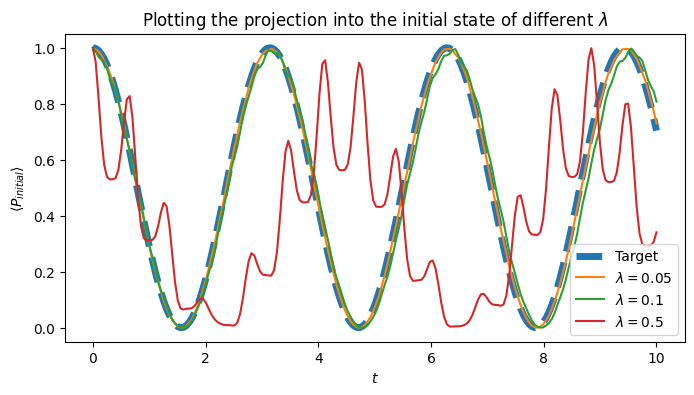

In [9]:
hadamard = qutip.core.gates.hadamard_transform(1)

zero_state_target = tensor([basis(2, 0) for _ in range(total_logic_qbits)])
initial_gad = zero_state_target

for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()

    initial_gad = tensor(initial_gad, plus_state_anc)

print_quantum_state_as_superposition(initial_gad)
initial_target = zero_state_target

times = np.linspace(0, 10, 200)

krylov_dim = 6

plt.figure(figsize=(8,4))
evolution = sesolve(tensor(hs[0]), initial_target, times, e_ops=[initial_target*initial_target.dag()])
plt.plot(times, evolution.expect[0], '--', label=r"Target", linewidth=5)

lambdas = [0.05, 0.1, 0.5]
for perturbation_factor in lambdas:
    print(f"perturbation_factor = {perturbation_factor}")
    tot_space, H_gad, ks, VLambda, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)
    H = sum([sum(hg) for hg in H_gad])

    evolution_gad = sesolve(H, initial_gad, times, e_ops=[initial_gad*initial_gad.dag()], options={'nsteps': 1e6, 'method': 'dop853'})
    # evolution_krylov = krylovsolve(H, initial_gad, times, e_ops=[initial_gad*initial_gad.dag()], krylov_dim=krylov_dim)

    plt.plot(times, evolution_gad.expect[0], label=r"$\lambda = $" + str(perturbation_factor))
    # plt.plot(times, evolution_krylov.expect[0], '--', label=r"Krylov")

plt.ylabel(r"$\langle P_{initial} \rangle$")
plt.xlabel(r"$t$")
plt.title(r"Plotting the projection into the initial state of different $\lambda$")
plt.legend()
plt.show()

/Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


P0 0.9999999999999998
P1 0.0
Step 1: t = [0, 1]

Execution time: 12.06 seconds


____________________________

P0 0.9814103774354519
P1 1.0455488351414518e-08
Step 2: t = [1, 2]

Execution time: 13.16 seconds


____________________________

P0 0.9957356148631507
P1 2.089365130846764e-05
Step 3: t = [2, 3]

Execution time: 8.85 seconds


____________________________

P0 0.9851977957563456
P1 0.006792085248497339
Step 4: t = [3, 4]

Execution time: 9.27 seconds


____________________________

P0 0.7676595139427207
P1 0.22638459053201582
Step 5: t = [4, 5]

Execution time: 13.00 seconds


____________________________

P0 0.49778035548006866
P1 0.4981642138065663
Step 6: t = [5, 6]

Execution time: 7.97 seconds


____________________________

P0 0.22623962805366865
P1 0.7676888382024643
Step 7: t = [6, 7]

Execution time: 13.61 seconds


____________________________

P0 0.006730863922907214
P1 0.9856606743468093
Step 8: t = [7, 8]

Execution time: 8.38 seconds


___________________________

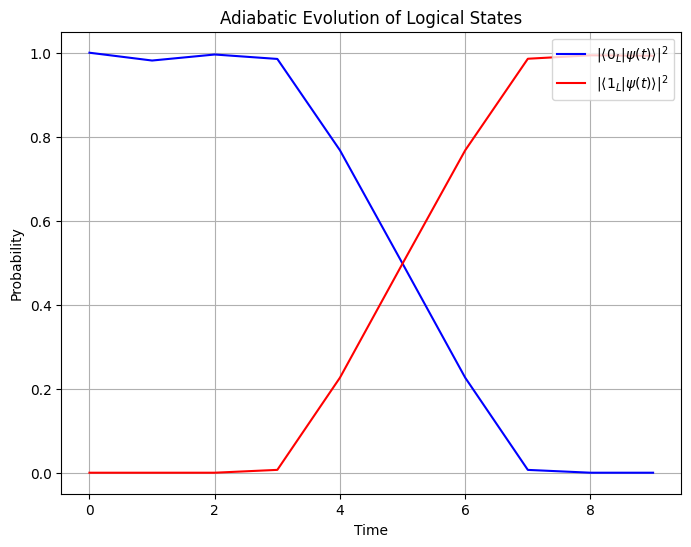

In [11]:
# Set up the parameters
dt = 1
T = 10
t_steps = np.arange(0, T + dt, dt)

sigma = 1
omega_max = 10


# Start time tracking
start_time = time.time()

start_time_dt = datetime.fromtimestamp(start_time)
formatted_time = start_time_dt.strftime("%Y-%m-%d %H:%M:%S")

# Set options for sesolve
options = Options(nsteps=1e7, atol=1e-3)

X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]

# Define the 4-qubit logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                   1j * tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                   1j * tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                   tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

# Modified H_S_0 with gadgets
Ep = 100
H_p = -Ep*sum([sum(hg) for hg in H_gad])

# Expanding the space of the one local operations of the RAP to the new space
X_L_all = tensor(X_L, tensor([I for _ in range(sum(ks))]))
Z_L_all = tensor(Z_L, tensor([I for _ in range(sum(ks))]))


initial_state = logical_zero
for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()
    initial_state = tensor(initial_state, plus_state_anc)


logical_one = tensor(X_L,tensor([I for _ in range(sum(ks))])) * initial_state 
    
# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
    return omega_t * X_L_all + delta_t * Z_L_all + H_p


P_init = initial_state * initial_state.dag()
P_one= logical_one * logical_one.dag()


# Arrays to store results
total_p_zero = []
total_p_one = []


# Iterative sesolve calculations
for i in range(len(t_steps) - 1):
    t_start = t_steps[i]
    t_end = t_steps[i + 1]
    t_range = np.linspace(t_start, t_end, 2)
    
    # Calculate e_ops manually for the final state
    p_zero = np.abs(expect(P_init, initial_state))
    p_one = np.abs(expect(P_one, initial_state))
    print("P0", p_zero)
    print("P1", p_one)
    
    # Log the probabilities at this step
    total_p_zero.append(p_zero)
    total_p_one.append(p_one)
    
    
    step_start_time = time.time()
    

    # Define the time-dependent Hamiltonian for this step
    H_td = QobjEvo(H_RAP, args={'omega_max': omega_max, 'T': T, 'sigma': sigma})
    
    result = sesolve(H_td, initial_state, t_range, options=options)

    # Extract final state from this step
    initial_state = result.states[-1]

    # Calculate step execution time
    step_end_time = time.time()
    step_elapsed_time = step_end_time - step_start_time
    
    print(f"Step {i + 1}: t = [{t_start}, {t_end}]\n")
    print(f"Execution time: {step_elapsed_time:.2f} seconds\n")
    print(f"\n____________________________\n")
    
# End time tracking
end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_hours = elapsed_time_seconds / 3600

end_time_dt = datetime.fromtimestamp(end_time)
formatted_time_end = end_time_dt.strftime("%Y-%m-%d %H:%M:%S")
    

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t_steps[:-1], total_p_zero, label=r'$| \langle 0_{L} | \psi(t) \rangle |^2$', color='blue')
plt.plot(t_steps[:-1], total_p_one, label=r'$| \langle 1_{L} | \psi(t) \rangle |^2$', color='red')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Adiabatic Evolution of Logical States')
plt.legend(loc='upper right')
plt.grid()
# plt.savefig("full_gad_15_qubit.png", format="png", dpi=300)
# plt.close()

# Print summary
print(f"Code execution time: {elapsed_time_seconds:.2f} seconds")
print(f"Code execution time: {elapsed_time_hours:.2f} hours")

Lambda is: 0.1


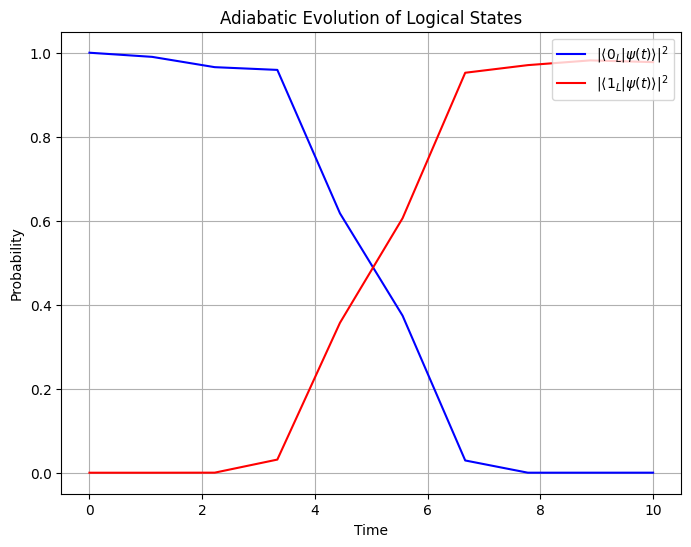

In [12]:
print("Lambda is:", perturbation_factor)

X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]

# Define the 4-qubit logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                   1j * tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                   1j * tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                   tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

# RAP time-dependent terms
T = 10
t = np.linspace(0, T, 10)
sigma = 1
omega_max = 10

# Modified H_S_0 with gadgets
Ep = 100
H_p = -Ep*sum([sum(hg) for hg in H_gad])

# Expanding the space of the one local operations of the RAP to the new space
X_L_all = tensor(X_L, tensor([I for _ in range(sum(ks))]))
Z_L_all = tensor(Z_L, tensor([I for _ in range(sum(ks))]))


initial_state = logical_zero
for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()
    initial_state = tensor(initial_state, plus_state_anc)


logical_one = tensor(X_L,tensor([I for _ in range(sum(ks))])) * initial_state 
    
# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
    return omega_t * X_L_all + delta_t * Z_L_all + H_p


P_init = initial_state * initial_state.dag()
P_one= logical_one * logical_one.dag()

# Solve the system with sesolve
args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
H_td = QobjEvo(H_RAP, args=args)

result = sesolve(H_td, initial_state, t, e_ops=[P_init, P_one], options={'nsteps': 1e6, 'atol':1e-2})
# options={'nsteps': 1e5, 'atol': 1e-2}

# Extract probabilities
p_zero = result.expect[0]
p_one = result.expect[1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, p_zero, label=r'$| \langle 0_{L} | \psi(t) \rangle |^2$', color='blue')
plt.plot(t, p_one, label=r'$| \langle 1_{L} | \psi(t) \rangle |^2$', color='red')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Adiabatic Evolution of Logical States')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [16]:
H = sum([sum(hg) for hg in H_gad])

eig, vec = H.eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1
print("H_eff", energies_eff)

eig, vec = tensor(h1).eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1
        
print("H_comp", energies_eff)

H_eff {-11: 16, -9: 16, 1211: 16, 1266: 32, 1400: 32, 1475: 16}
H_comp {-1: 8, 1: 8}


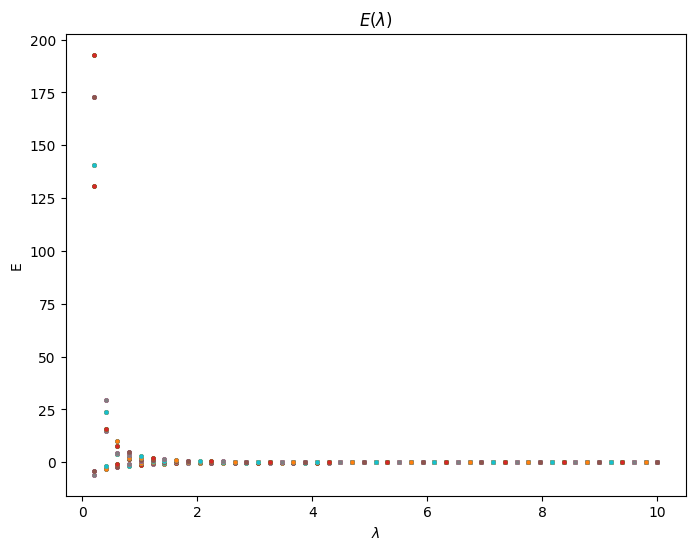

In [21]:
lambdas = np.linspace(0, 10, 50)

total_logic_qbits = 3  # Number of logical qubits

h_3 = [X, Y, Z]
hs = [h_3]
k = sum([1 for i in hs[0] if i != I])

plt.figure(figsize=(8,6))

for perturbation_factor in lambdas[1:]:
    tot_space, H_gad, ks, VLambda, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)
    
    eig, vec = sum([sum(hg) for hg in H_gad]).eigenstates()
    for e in eig:
        plt.scatter(perturbation_factor, e, s=5)


plt.title(r"$E(\lambda)$")
plt.xlabel(r"$\lambda$")
plt.ylabel("E")
plt.show()

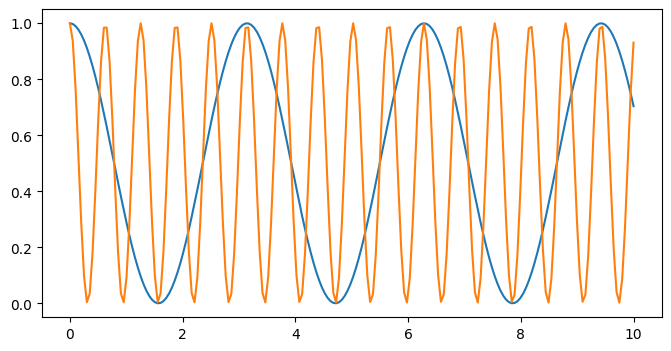

In [150]:
initial = basis(2, 0)

res1 = sesolve(X, initial, t, e_ops=[initial*initial.dag()])
res2 = sesolve(5*X, initial, t, e_ops=[initial*initial.dag()])

plt.figure(figsize=(8,4))
plt.plot(t, res1.expect[0])
plt.plot(t, res2.expect[0])
plt.show()